## Analysis of Qualitative Assessment Results | Rapid Scene Categorization

#### Imports, Constant Definition and Functions

In [20]:
import os
import cv2
import json
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score
# -----------------------------------------------------------------------------------------------------------------------------

# Constants

## Generated images marker
GENERATED = 0

## Real images marker
REAL = 1

# -----------------------------------------------------------------------------------------------------------------------------

# Function that gets the answers and labels in a list format
def get_answers(json_filename):
   
    # Open the JSON file
    f = open(json_filename)

    # Read the JSON file
    data = json.load(f)

    # Get the JSON data
    answers = []
    expected = []
    for item in data[2]:

        # Specialist answer of each image
        answer = GENERATED if item["type"] == "Gerada" else REAL

        # True label of the image (real or generated)
        label = GENERATED if "seed" in item["filename"] else REAL

        # Store it inside a list
        answers.append(answer)
        expected.append(label)

    # Close the JSON file
    f.close()
    
    return(answers, expected)
# -----------------------------------------------------------------------------------------------------------------------------

# Function that filter the answers considering only the informed label
def filter_answers_by_label(answers, expected, label):
    
    # Get the indexes where the element is igual to the informed label
    indexes = np.where(np.array(expected) == label)[0]
    
    # Build the new lists using these indexes
    filtered_answers = []
    filtered_expected = []
    for index in indexes:
        filtered_answers.append(answers[index])
        filtered_expected.append(expected[index])
        
    return(filtered_answers, filtered_expected)
# -----------------------------------------------------------------------------------------------------------------------------

# Function that calculates the Pearson Correlation between two lists
def calc_pearson_corr(var_1, var_2):   
    pearson_corr = scipy.stats.pearsonr(var_1, var_2)
    return(pearson_corr)
# -----------------------------------------------------------------------------------------------------------------------------

# Function that calculates and plots the confusion matrix
def calc_confusion_matrix(answers, expected, show=True):
    
    # Calculates
    cm = confusion_matrix(expected, answers, labels=[0, 1])
    
    # Plot it
    if(show):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Generated", "Real"])
        disp.plot()
        plt.title(show)
        plt.show()
        
    return(cm)
# -----------------------------------------------------------------------------------------------------------------------------

# Funtion that calculates generic metrics
def calc_metric(answers, expected, metric):
    result = metric(expected, answers)
    return(round(result, 4))
# -----------------------------------------------------------------------------------------------------------------------------

# Function that calculates all the metrics
def get_all_metrics(answers, expected, title):
    
    # Calc the Pearson Correlation
    pearson_corr = calc_pearson_corr(answers, expected)
    print("\n  Pearson Correlation:")
    print("    - Correlation: {}".format(round(pearson_corr[0], 4)))
    print("    - P-value: {}".format(round(pearson_corr[1], 4)))
    
    # Calc the metrics
    precision = calc_metric(answers, expected, precision_score)
    recall = calc_metric(answers, expected, recall_score)
    accuracy = calc_metric(answers, expected, accuracy_score)
    print("\n  Precision: {}%".format(precision * 100.0))
    print("\n  Recall: {}%".format(recall * 100.0))
    print("\n  Accuracy: {}%".format(accuracy * 100.0))

    # Calc and plot the confusion matrix
    calc_confusion_matrix(answers, expected, show="Confusion Matrix | {}".format(title))
# -----------------------------------------------------------------------------------------------------------------------------

# Function that calculates the Pearson Correlation between specialists
def correlation_between_specialists(json_filenames, template_names=["1", "2", "3"]):
    answers = []
    names = []
    for filename in json_filenames:

        # Save the doctor name to identify the comparisons later
        for template_name in template_names:
            if(template_name in filename):
                names.append(template_name)
    
        # Open the JSON file
        f = open(filename)

        # Read the JSON file
        data = json.load(f)

        # Get the JSON data
        specialist_answers = []
        
        # Specialist answer of each image
        for item_ in data[2]:
            answer = GENERATED if item_["type"] == "Gerada" else REAL

            # Store it inside a list
            specialist_answers.append(answer)
            
        # Store all the answers inside a list
        answers.append(specialist_answers)
        
        # Close the JSON file
        f.close()
    
    for specialist_1_id in range(len(answers)-1):
        for specialist_2_id in range(specialist_1_id + 1, len(answers)):

            # Calc the Pearson Correlation
            pearson_corr = scipy.stats.pearsonr(answers[specialist_1_id], answers[specialist_2_id])
            
            print("\nPearson Correlation | {} and {}:".format(names[specialist_1_id], names[specialist_2_id]))
            print("  - Correlation: {:.4}".format(pearson_corr[0]))
            print("  - P-value: {:.4}".format(pearson_corr[1]))
# -----------------------------------------------------------------------------------------------------------------------------

# Function that returns the indexes where the two answers are wrong
def check_same_errors(expected, answers_1, answers_2, answers_3):
    
    # For each image
    ind_errors = []
    for index in range(len(expected)):
        
        # Ignore real images
        if(expected[index] == REAL):
            continue
        
        # Check if the two answers are wrong
        if(answers_1[index] != expected[index]) and (answers_2[index] != expected[index]) and (answers_3[index] != expected[index]):
            ind_errors.append(index)
        
    return(ind_errors)
# -----------------------------------------------------------------------------------------------------------------------------

# Function that returns the indexes where the two answers are right
def check_same_hits(expected, answers_1, answers_2, answers_3):
    
    # For each image
    ind_hits = []
    for index in range(len(expected)):
        
        # Ignore real images
        if(expected[index] == REAL):
            continue
            
        # Check if the two answers are right
        if(answers_1[index] == expected[index]) and (answers_2[index] == expected[index]) and (answers_3[index] == expected[index]):
            ind_hits.append(index)
        
    return(ind_hits)
# -----------------------------------------------------------------------------------------------------------------------------

# Function that retrieves the image name by id
def get_filename_by_index(indexes, json_filename):
    
    # Open the JSON file
    f = open(json_filename)

    # Read the JSON file
    data = json.load(f)
    
    # Get filename
    filenames = []
    for index in indexes:
        filename = data[2][index]["filename"]
        filenames.append(filename)
        
    return(filenames)
# -----------------------------------------------------------------------------------------------------------------------------

# Function that plot all the images inside the "filenames" list
def plot_images_by_filename(filenames, root_dir="web_app/assets/crc_images"):
    
    for filename in filenames:
        
        # Define the full path
        path = os.path.join(root_dir, filename)
        
        # Read the image
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
        
        # Plot it
        plt.figure(figsize = (10, 3))
        plt.imshow(image)      
        plt.axis('off')
        print(filename)
        plt.show()
# -----------------------------------------------------------------------------------------------------------------------------

#### Specialist 1

General:

  Pearson Correlation:
    - Correlation: 0.0037
    - P-value: 0.9708

  Precision: 28.12%

  Recall: 64.29%

  Accuracy: 44.0%


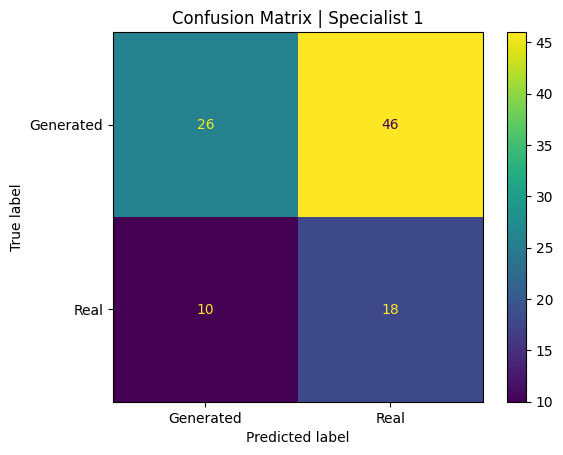

In [21]:
# Read the answers
answers, expected = get_answers("specialist_answers/CRC_specialist_1.json")

print("General:")
get_all_metrics(answers, expected, "Specialist 1")

In [22]:
print("Filtering:")
print("\nOnly Generated Images:")
gen_answers, gen_expected = filter_answers_by_label(answers, expected, GENERATED)
gen_accuracy = calc_metric(gen_answers, gen_expected, accuracy_score)
print("  Accuracy: {}%".format(gen_accuracy * 100.0))

print("\nOnly Real Images:")
real_answers, real_expected = filter_answers_by_label(answers, expected, REAL)
real_accuracy = calc_metric(real_answers, real_expected, accuracy_score)
print("  Accuracy: {}%".format(real_accuracy * 100.0))

Filtering:

Only Generated Images:
  Accuracy: 36.11%

Only Real Images:
  Accuracy: 64.29%


#### Specialist 2

General:

  Pearson Correlation:
    - Correlation: 0.418
    - P-value: 0.0

  Precision: 40.58%

  Recall: 100.0%

  Accuracy: 59.0%


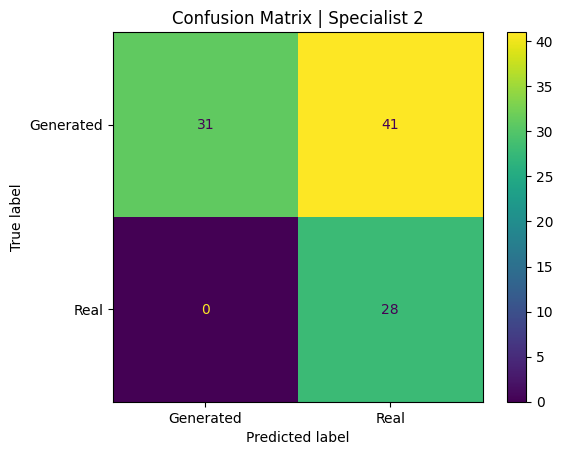

In [23]:
# Read the answers
answers, expected = get_answers("specialist_answers/CRC_specialist_2.json")

print("General:")
get_all_metrics(answers, expected, "Specialist 2")

In [24]:
print("Filtering:")
print("\nOnly Generated Images:")
gen_answers, gen_expected = filter_answers_by_label(answers, expected, GENERATED)
gen_accuracy = calc_metric(gen_answers, gen_expected, accuracy_score)
print("  Accuracy: {}%".format(round(gen_accuracy * 100.0, 2)))

print("\nOnly Real Images:")
real_answers, real_expected = filter_answers_by_label(answers, expected, REAL)
real_accuracy = calc_metric(real_answers, real_expected, accuracy_score)
print("  Accuracy: {}%".format(real_accuracy * 100.0))

Filtering:

Only Generated Images:
  Accuracy: 43.06%

Only Real Images:
  Accuracy: 100.0%


#### Specialist 3

General:

  Pearson Correlation:
    - Correlation: 0.1368
    - P-value: 0.1749

  Precision: 33.33%

  Recall: 67.86%

  Accuracy: 53.0%


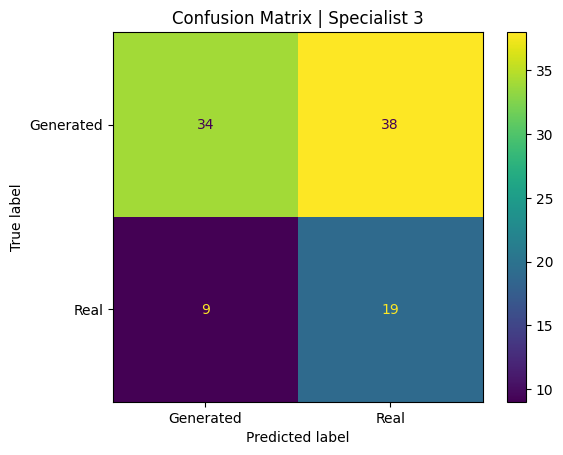

In [25]:
# Read the answers
answers, expected = get_answers("specialist_answers/CRC_specialist_3.json")

print("General:")
get_all_metrics(answers, expected, "Specialist 3")

In [26]:
print("Filtering:")
print("\nOnly Generated Images:")
gen_answers, gen_expected = filter_answers_by_label(answers, expected, GENERATED)
gen_accuracy = calc_metric(gen_answers, gen_expected, accuracy_score)
print("  Accuracy: {}%".format(round(gen_accuracy * 100.0, 2)))

print("\nOnly Real Images:")
real_answers, real_expected = filter_answers_by_label(answers, expected, REAL)
real_accuracy = calc_metric(real_answers, real_expected, accuracy_score)
print("  Accuracy: {}%".format(real_accuracy * 100.0))


Filtering:

Only Generated Images:
  Accuracy: 47.22%

Only Real Images:
  Accuracy: 67.86%


### Correlation Between Specialist 1, Specialist 2 and Specialist 3

In [27]:
json_filenames = [
    "specialist_answers/CRC_specialist_1.json",
    "specialist_answers/CRC_specialist_2.json",
    "specialist_answers/CRC_specialist_3.json"
]
correlation_between_specialists(json_filenames)


Pearson Correlation | 1 and 2:
  - Correlation: -0.007207
  - P-value: 0.9433

Pearson Correlation | 1 and 3:
  - Correlation: -0.1885
  - P-value: 0.06032

Pearson Correlation | 2 and 3:
  - Correlation: 0.2476
  - P-value: 0.01299


### Generated Images Where All the Experts Made Mistakes

Number of wrong answers by Specialist 1: 46
Number of wrong answers by Specialist 2: 41
Number of wrong answers by Specialist 3: 38
Number of common wrong answers: 15
1_seed0776.png


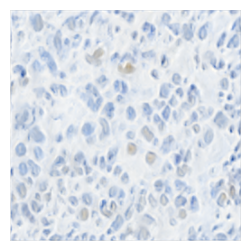

2_seed0514.png


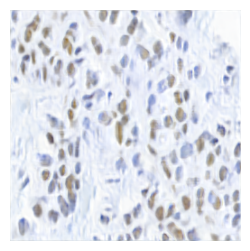

1_seed0335.png


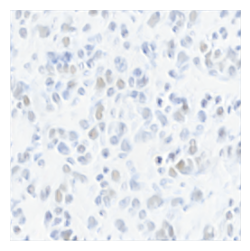

2_seed0020.png


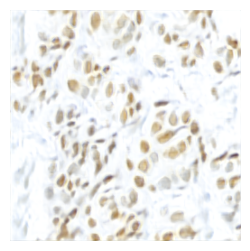

1_seed0754.png


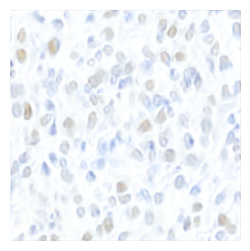

1_seed0514.png


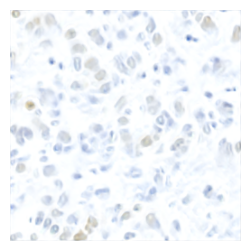

1_seed0088.png


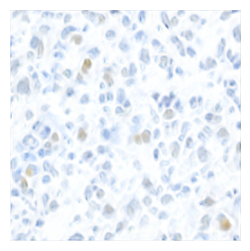

1_seed0141.png


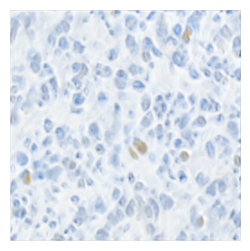

0_seed0908.png


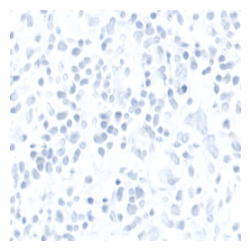

3_seed0959.png


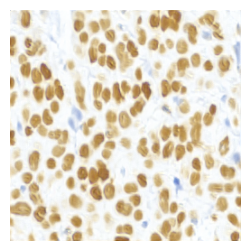

1_seed0814.png


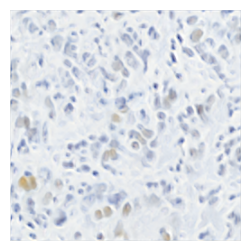

3_seed1000.png


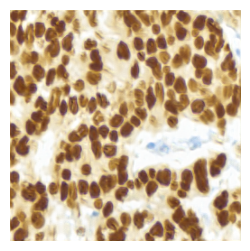

0_seed0449.png


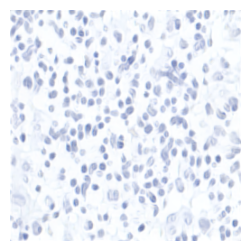

1_seed0606.png


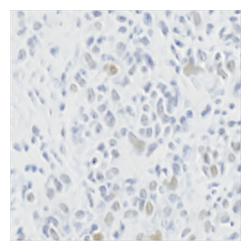

0_seed0191.png


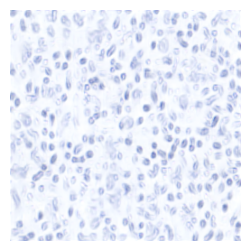

In [28]:
# Answers 1 -> Specialist 1
answers_1, expected = get_answers("specialist_answers/CRC_specialist_1.json")

# Answers 1 -> Specialist 2
answers_2, _ = get_answers("specialist_answers/CRC_specialist_2.json")

# Answers 3 -> Specialist 3
answers_3, _ = get_answers("specialist_answers/CRC_specialist_3.json")

# Get the indexes where the three experts made mistakes
indexes = check_same_errors(expected, answers_1, answers_2, answers_3)

# Get the filenames (using the indexes)
error_filenames = get_filename_by_index(indexes, json_filenames[0])

# Considering only generated images
print("Number of wrong answers by Specialist 1: 46")
print("Number of wrong answers by Specialist 2: 41")
print("Number of wrong answers by Specialist 3: 38")
print("Number of common wrong answers: {}".format(len(error_filenames)))

# Plot the images
plot_images_by_filename(error_filenames)

### Generated Images Where All the Experts Got It Right

Number of right answers by Specialist 1: 26
Number of right answers by Specialist 2: 31
Number of right answers by Specialist 3: 34
Number of common right answers: 4
0_seed0718.png


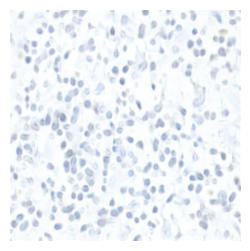

0_seed0075.png


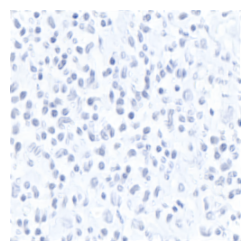

0_seed0450.png


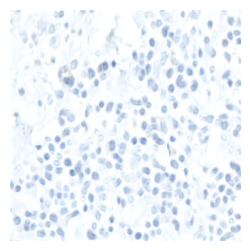

1_seed0909.png


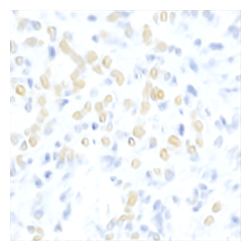

In [29]:
# Answers 1 -> Specialist 1
answers_1, expected = get_answers("specialist_answers/CRC_specialist_1.json")

# Answers 2 -> Specialist 2
answers_2, _ = get_answers("specialist_answers/CRC_specialist_2.json")

# Answers 3 -> Specialist 3
answers_3, _ = get_answers("specialist_answers/CRC_specialist_3.json")

# Get the indexes where the three experts got it right
indexes = check_same_hits(expected, answers_1, answers_2, answers_3)

# Get the filenames (using the indexes)
hits_filenames = get_filename_by_index(indexes, json_filenames[0])
print("Number of right answers by Specialist 1: 26")
print("Number of right answers by Specialist 2: 31")
print("Number of right answers by Specialist 3: 34")
print("Number of common right answers: {}".format(len(hits_filenames)))

# Plot the images
plot_images_by_filename(hits_filenames)

### Plot of the Confusion Matrices Together

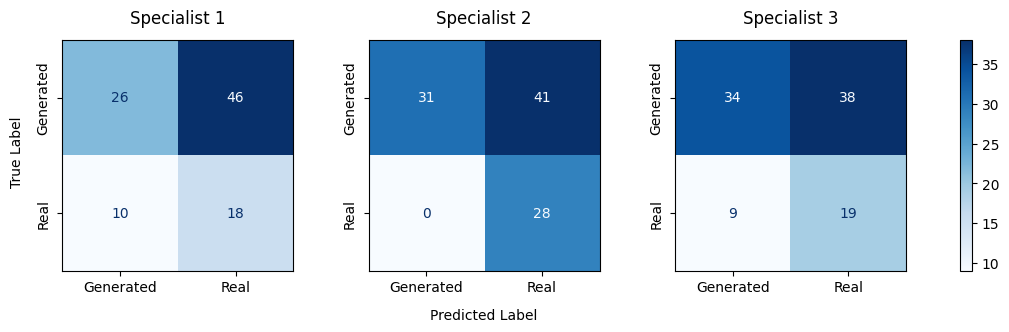

In [30]:
# Answers 1 -> Specialist 1
answers_1, expected = get_answers("specialist_answers/CRC_specialist_1.json")

# Answers 2 -> Specialist 2
answers_2, _ = get_answers("specialist_answers/CRC_specialist_2.json")

# Answers 3 -> Specialist 3
answers_3, _ = get_answers("specialist_answers/CRC_specialist_3.json")

# Calculates the Confusion Matrix and get the display
cm_1 = calc_confusion_matrix(answers_1, expected, show=False)
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=["Generated", "Real"])
cm_2 = calc_confusion_matrix(answers_2, expected, show=False)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=["Generated", "Real"])
cm_3 = calc_confusion_matrix(answers_3, expected, show=False)
disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=["Generated", "Real"])

# Define the subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 3))

# Define the settings to plot the first Confusion Matrix
disp_1.plot(ax=axes[0], cmap=plt.cm.Blues)
disp_1.ax_.set_title("Specialist 1", pad=12)
disp_1.im_.colorbar.remove()
disp_1.ax_.set_xlabel('')
disp_1.ax_.set_ylabel('')
axes[0].set_yticklabels([]) 

# Define the settings to plot the second Confusion Matrix
disp_2.plot(ax=axes[1], cmap=plt.cm.Blues)
disp_2.ax_.set_title("Specialist 2", pad=12)
disp_2.im_.colorbar.remove()
disp_2.ax_.set_xlabel('')
disp_2.ax_.set_ylabel('')

# Define the settings to plot the third Confusion Matrix
disp_3.plot(ax=axes[2], cmap=plt.cm.Blues)
disp_3.ax_.set_title("Specialist 3", pad=12)
disp_3.im_.colorbar.remove()
disp_3.ax_.set_xlabel('')
disp_3.ax_.set_ylabel('')

# Define the y axis labels of each subplot
axes[0].tick_params(axis='y', which='major', pad=15)
axes[0].set_yticklabels(["Generated", "Real"], rotation=90, horizontalalignment='left', verticalalignment='center')
axes[1].tick_params(axis='y', which='major', pad=15)
axes[1].set_yticklabels(["Generated", "Real"], rotation=90, horizontalalignment='left', verticalalignment='center')
axes[2].tick_params(axis='y', which='major', pad=15)
axes[2].set_yticklabels(["Generated", "Real"], rotation=90, horizontalalignment='left', verticalalignment='center')

# Define the general labels
fig.text(0.405, -0.05, 'Predicted Label', ha='left')
fig.text(0.105, 0.4, 'True Label', rotation="vertical")


# Plot the color bar (right side)
fig.colorbar(disp_3.im_, ax=axes)

# Plot it
plt.show()

# Save it
fig.savefig("confusion_matrices.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1, dpi=1200)
